In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os.path
import scipy.misc
from datetime import datetime
from time import sleep
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Calibration and Undistortion 

In [2]:

def find_corners(gray_chessboards, x_dim, y_dim, build_pickle=False):
    """
    Generate set of images points and object points
    for chessboard corners
    """
    pickle_path = "./camera_cal/corners_pickle.p"
    if build_pickle or (not os.path.exists(pickle_path)):
        objpoints = []
        imgpoints = []
        images = []

        objp = np.zeros((x_dim*y_dim, 3), np.float32)
        objp[:, :2] = np.mgrid[0:x_dim, 0:y_dim].T.reshape(-1, 2)

        for (gray_chessboard, img) in gray_chessboards:
            ret, corners = cv2.findChessboardCorners(gray_chessboard, (x_dim, y_dim), None)
            if ret == True:
                imgpoints.append(corners)
                objpoints.append(objp)
                
            if ret == True:
                cv2.drawChessboardCorners(img, (x_dim, y_dim), corners, ret)
                plt.figure()
                plt.imshow(img)
                
        corners_pickle = {}
        corners_pickle["objpoints"] = objpoints
        corners_pickle["imgpoints"] = imgpoints
        
        if len(imgpoints) != 0: 
            pickle.dump( corners_pickle, open( pickle_path, "wb" ) )
        
        return (objpoints, imgpoints)

    corners_pickle = pickle.load( open( pickle_path, "rb" ) )
    return (corners_pickle["objpoints"], corners_pickle["imgpoints"])

In [3]:
def undistor_image(img, obj_points, img_points, build_pickle=False):
    """
    Undistort an image given obj_points, img_points
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pickle_path = "./camera_cal/wide_dist_pickle.p"
    if build_pickle or (not os.path.exists(pickle_path) ):
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                           img_points,
                                                           (img.shape[1], img.shape[0]),
                                                           None, None)
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        dist_pickle["ret"] = ret
        dist_pickle["rvecs"] = rvecs
        dist_pickle["tvecs"] = tvecs
        
        pickle.dump( dist_pickle, open( pickle_path, "wb" ) )

        return cv2.undistort(gray, mtx, dist, None, mtx)

    dist_pickle = pickle.load( open( pickle_path, "rb" ) )
    return cv2.undistort(img, dist_pickle["mtx"], dist_pickle["dist"], None, dist_pickle["mtx"])


In [4]:
images_path = glob.glob("./camera_cal/*.jpg")
calibration_gray = [(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY), cv2.imread(path) ) for path in images_path]
calibration_images = [cv2.imread(path) for path in images_path]
objpoints, imgpoints = find_corners(calibration_gray, 9, 6, build_pickle=False)

In [5]:
def debug_images(img1, img2, title1, title2):
    """
    Debug image by showing a set the titles
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img1, cmap='gray')
    ax1.set_title(title1, fontsize=40)

    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2, fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

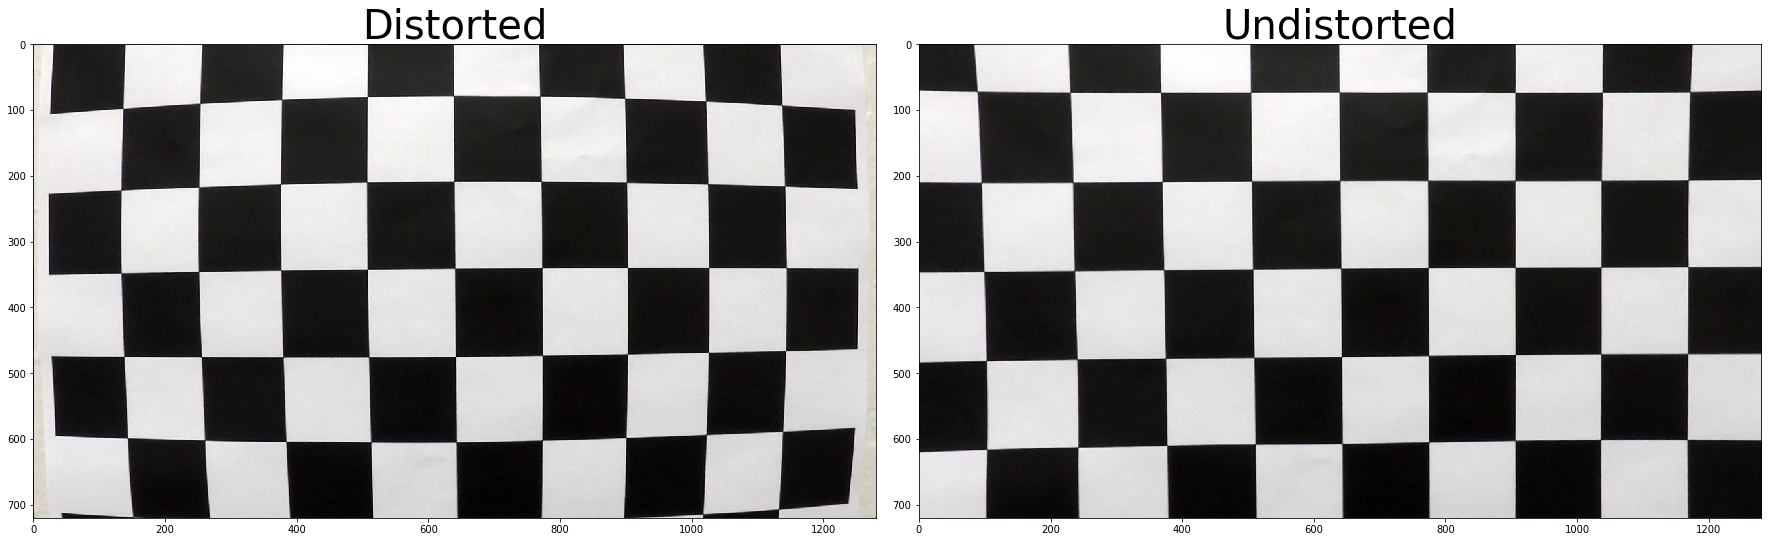

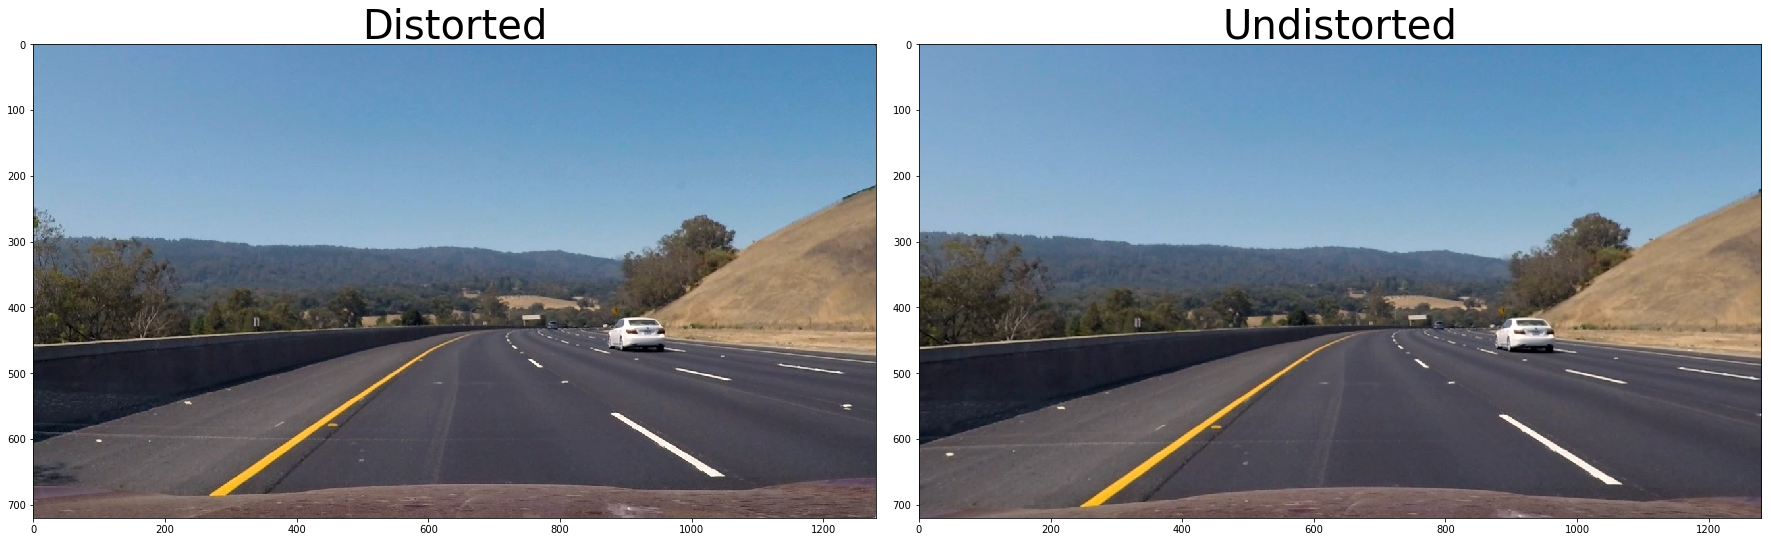

In [6]:
test_dist = mpimg.imread("./camera_cal/calibration1.jpg")
test_dist2 = mpimg.imread("./test_images/test3.jpg")
test_undist = undistor_image(test_dist, objpoints, imgpoints)
test_undist2 = undistor_image(test_dist2, objpoints, imgpoints)
debug_images(test_dist, test_undist, "Distorted", "Undistorted")
debug_images(test_dist2, test_undist2, "Distorted", "Undistorted")

## This part contains functions for color and gradients to detect lane lines

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Returns binary output of image, filtering out pixels
    that are not in the desired direction(tresh)
    """
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_x = np.absolute(x)
    abs_y = np.absolute(y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arc_xy = np.arctan2(abs_y, abs_x)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(arc_xy)
    binary_output[(arc_xy >= thresh[0]) & (arc_xy <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return binary_output

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Apply sobel to an image in given direction
    returns binary image filtered by thresholds
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    derivative = (1, 0)

    if orient == 'y':
        derivative = (0, 1)

    sobel = cv2.Sobel(gray, cv2.CV_64F, derivative[0], derivative[1], ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary_output

In [9]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Returns binary image, filters out by magnitude
    """
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image    

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(x**2 + y**2)
    scaled = np.uint8(mag/(np.max(mag)/255))
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])] = 1

    return binary_output


In [10]:
def sobel(image, ksize=3, xy_thresh=(20, 255), mag_thresh_=(20, 200), dir_thresh=(0.3, 1.2)):
    """
    Returns a filtered binary image combining sobel in x and y
    magnitude and direction
    """
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=xy_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=xy_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=mag_thresh_)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresh)

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return  combined

In [11]:
def channel_thresh(channel, thresh=(20, 255)):
    """
    Returns a filtered channel i.e one the RGB or HSV etc
    """
    ch_binary = np.zeros_like(channel)
    ch_binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    return ch_binary


In [12]:
def color_and_gradient_comb(img, debug=(False, False)):
    """
    Returns a combination gradient of image and selected channels
    """
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    s1_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    s2_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    R_channel = img[:,:, 0]
 
    # Threshold color channel
    s1_channel_bin = channel_thresh(s1_channel, thresh=(160, 255))
    s2_channel_bin = channel_thresh(s2_channel, thresh=(150, 255))
    l_channel_bin  = channel_thresh(l_channel, thresh=(220, 255))
    v_channel_bin  = channel_thresh(v_channel, thresh=(110, 255))
    R_channel_bin  = channel_thresh(R_channel, thresh=(210, 255))
    comb_channel = np.zeros_like(s1_channel_bin)
    comb_channel[((s1_channel_bin == 1)|
                 (s2_channel_bin == 1) |
                 (l_channel_bin == 1)) &
                 (v_channel_bin == 1)  |
                 (R_channel_bin == 1)] = 1
    
    #sobel on x and y, mag and dir
    dxdy_img = sobel(img, ksize=3, xy_thresh=(30, 250), mag_thresh_=(30, 250), dir_thresh=(-1.0, 1.0))

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    stacked = np.dstack(( np.zeros_like(dxdy_img), dxdy_img, comb_channel))
    all_comb = np.zeros_like(dxdy_img)
    all_comb[(dxdy_img == 1) | (comb_channel == 1)] = 1
     
    if debug[0] or debug[1]:
        #plot original image
        if debug[0]:
        #plot channels vs binaries
            debug_images(s1_channel, s1_channel_bin, 'S1 CH', 'S1 BIN')
            debug_images(s2_channel, s2_channel_bin, 'S2 CH', 'S2 BIN')
            debug_images(l_channel, l_channel_bin, 'L CH', 'L BIN')
            debug_images(v_channel, v_channel_bin, 'V CH', 'V BIN')
            debug_images(R_channel, R_channel_bin, 'R CH', 'R BIN')
        #plot gradient vs channel comb
        if debug[1]:
            debug_images(dxdy_img, comb_channel, 'Derivative', 'Channel')
            #plot stacked of gradient and channel combinations
            debug_images(stacked, all_comb, 'Stacked dx+comb', 'Combined dx+comb')
        debug_images(img, img, 'IMG', 'IMG')

    return all_comb

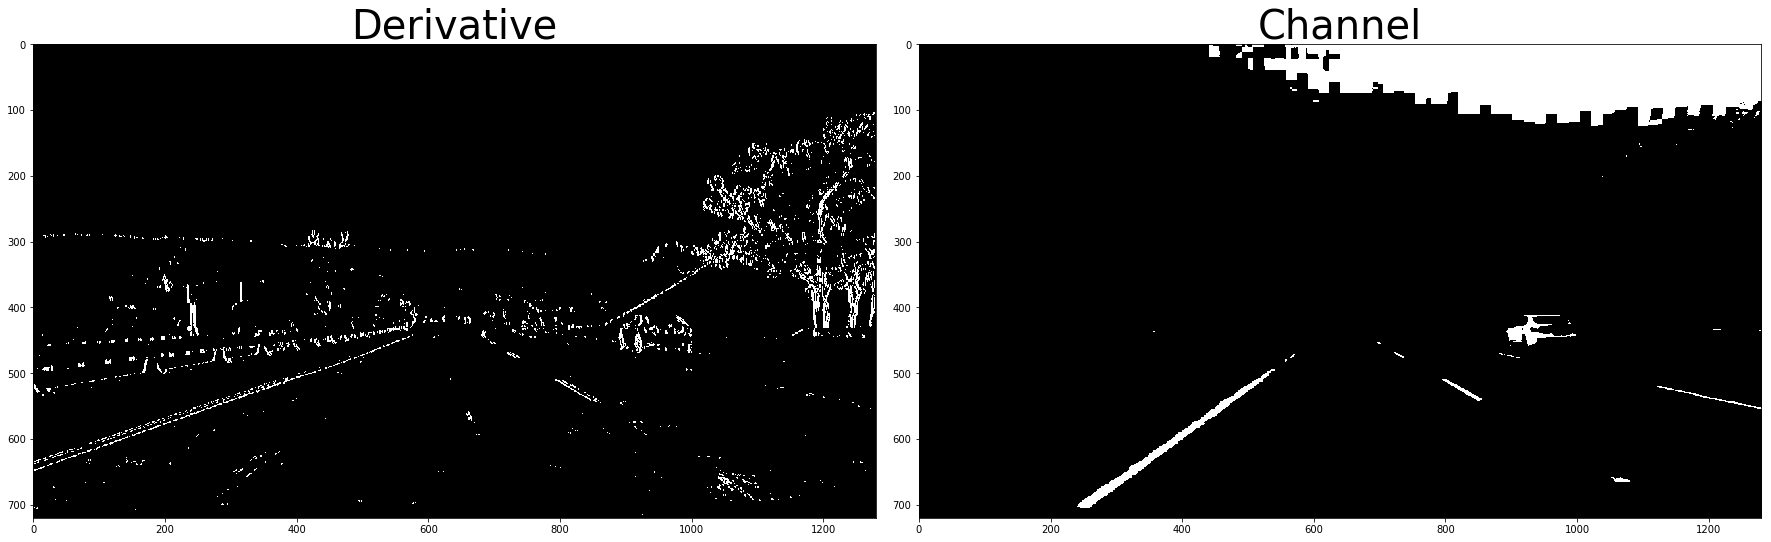

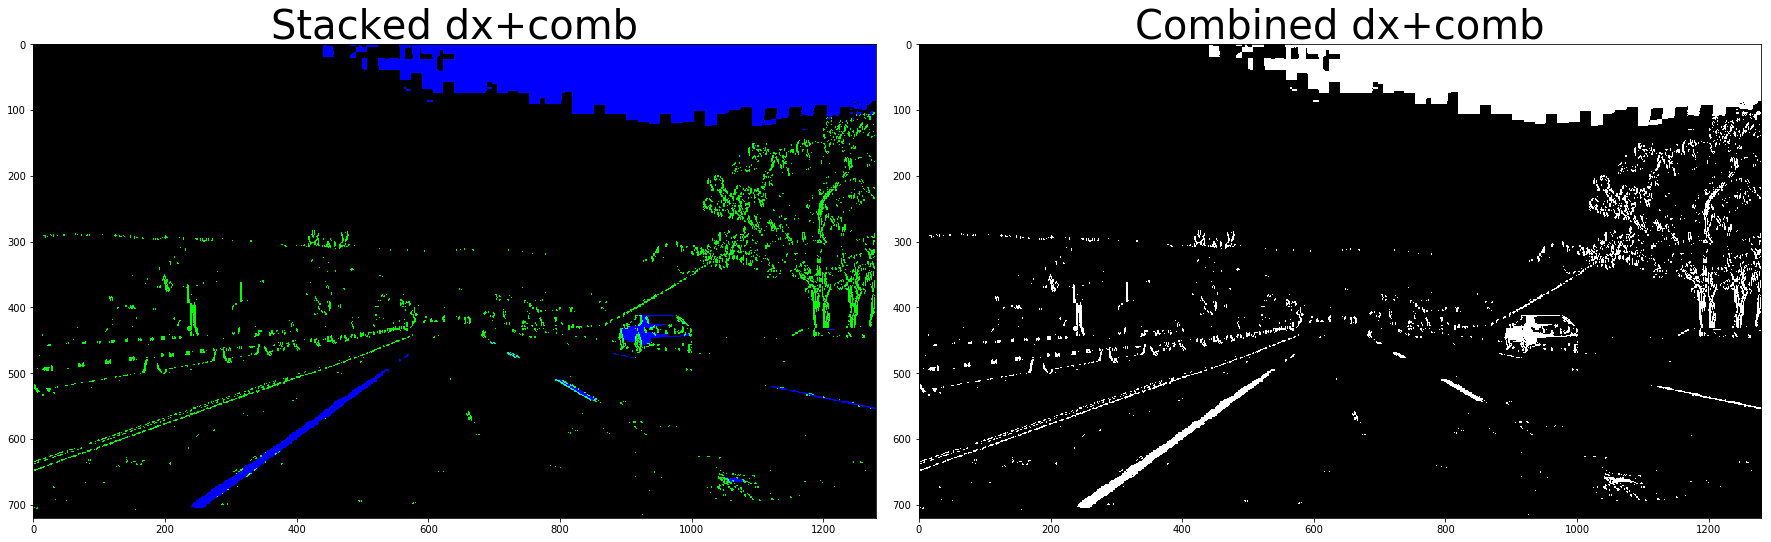

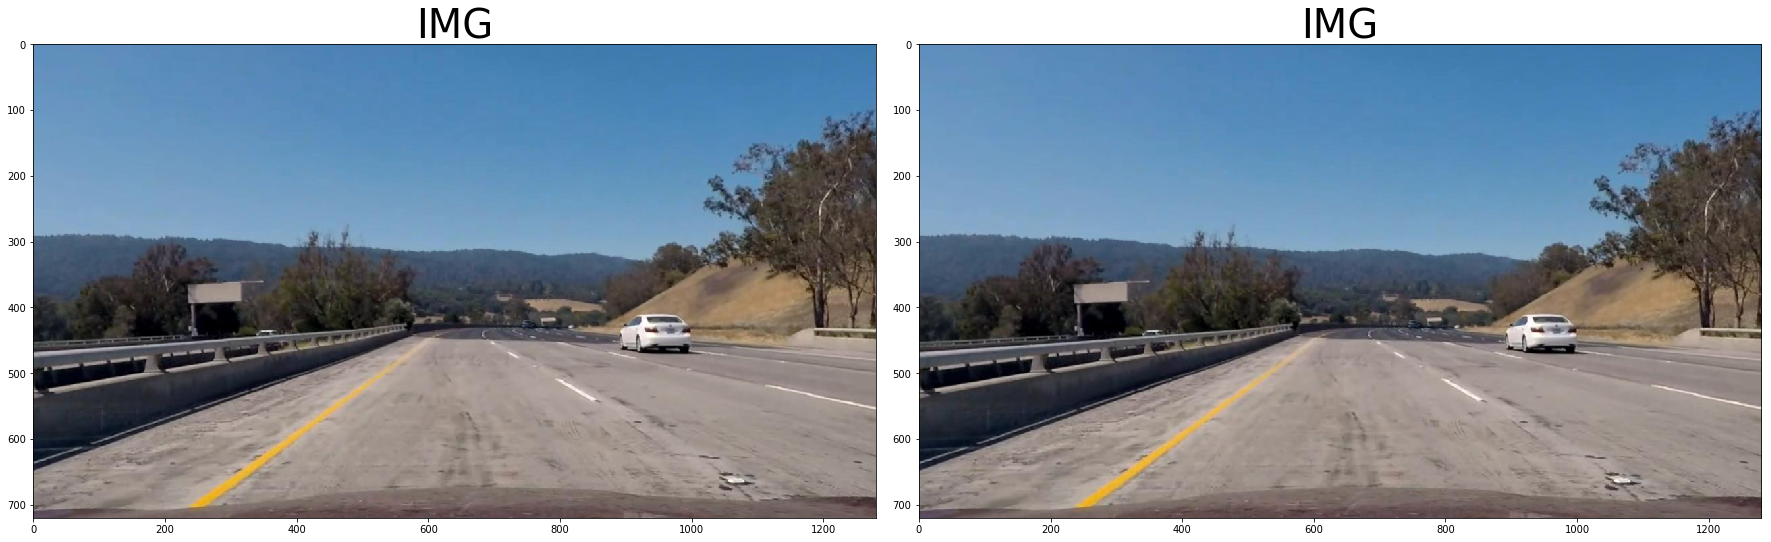

In [13]:
##testing gradient and channels
img1 = mpimg.imread('./test_images/test1.jpg')
img2 = mpimg.imread('./test_images/test4.jpg')
img3 = mpimg.imread('./test_images/test5.jpg')
img4 = mpimg.imread('./test_images/test6.jpg')
img5 = mpimg.imread('./test_images/color-shadow-example.jpg')
img6 = mpimg.imread("debug/2017_05_02_00_14_32_064.jpg")
img7 = mpimg.imread("debug/2017_05_02_00_14_32_368.jpg")
img8 = mpimg.imread("debug/2017_05_02_00_14_32_667.jpg")

img9 = mpimg.imread("debug/2017_05_02_00_16_59_340.jpg")
img10 = mpimg.imread("debug/2017_05_02_00_16_59_643.jpg")
img11 = mpimg.imread("debug/2017_05_02_00_16_59_986.jpg")

_=color_and_gradient_comb(undistor_image(img7, objpoints, imgpoints), debug=(False, True) )

## Perspective Transform

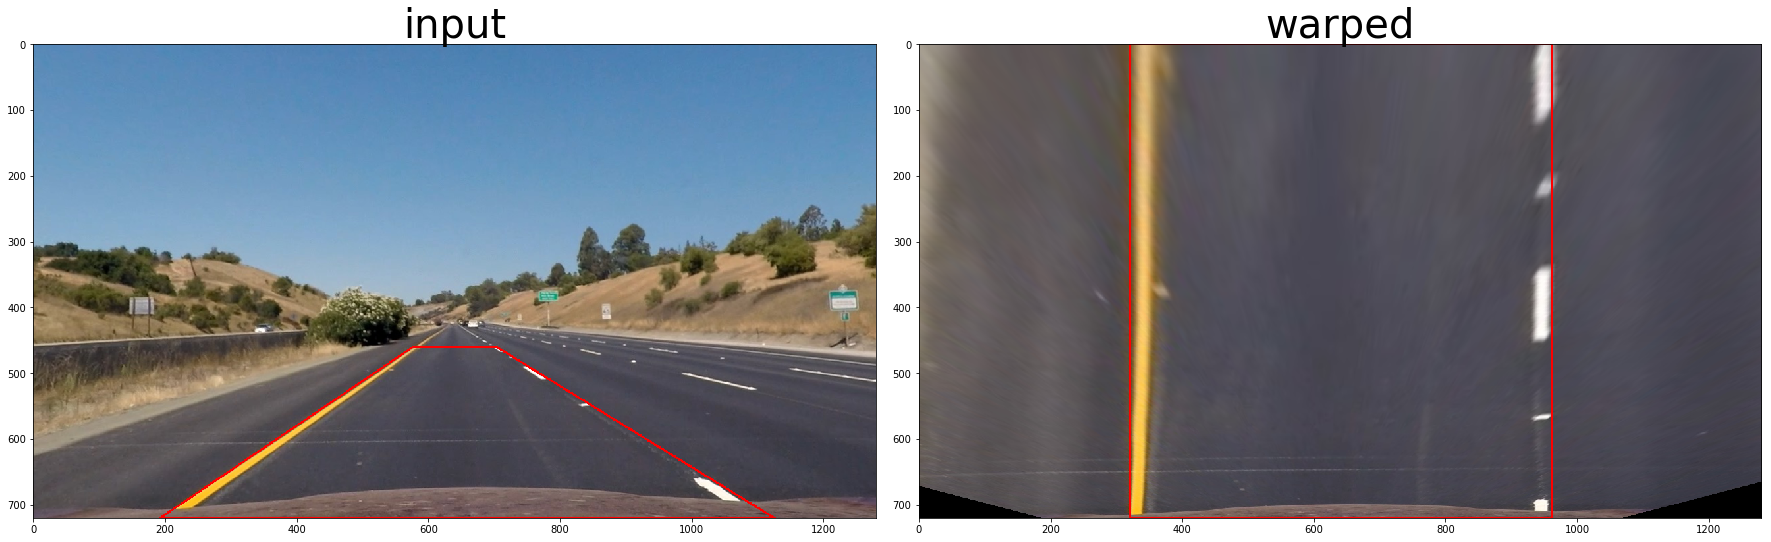

In [14]:
def warp(img, debug=False):
    """
    Returns a warped image and its inverse Matrix
    """
    img = np.copy(img)
    shape = img.shape

    src = np.float32(
        [
            [.55*shape[1], .64*shape[0]],
            [.45*shape[1], .64*shape[0]],
            [.15*shape[1], shape[0]],
            [.88*shape[1], shape[0]]
        ])
    _src = src.reshape((-1,1,2)).astype(int)
    _input = cv2.polylines(np.copy(img),[_src],True,(255,0,0), 2)

    dst = np.float32(
        [
            [.75*shape[1], 0],
            [.25*shape[1], 0],
            [.25*shape[1], shape[0]],
            [.75*shape[1], shape[0]]
        ])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, (shape[1], shape[0]), flags=cv2.INTER_LINEAR)
    _dst = dst.reshape((-1,1,2)).astype(int)
    _out_put = cv2.polylines(np.copy(warped),[_dst],True,(255,0,0), 2)

    if debug:
        debug_images(_input, _out_put, 'input', 'warped')
    return (np.uint8(warped), Minv)

img4 = mpimg.imread('./test_images/straight_lines1.jpg')
img4u = undistor_image(img4, objpoints, imgpoints, build_pickle=False)
_ =warp(img4u, debug=True)


## Finding Lane Lines

In [15]:
def radius(ploty, leftx, rightx, height_m=30.0, width_m=3.7, height_px=720.0, width_px=1280.0):
    """
    Compute the radius of a line
    """
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = height_m/height_px # meters per pixel in y dimension
    xm_per_pix = width_m/width_px # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    middle = (leftx[-1] + rightx[-1])//2
    carpos = ((width_px//2) - middle)*xm_per_pix
    return (left_curverad, right_curverad, carpos)

In [16]:
def plot_lane_area(warped, undist, Minv, ploty, left_fitx, right_fitx, debug=False):
    """
    Plots the area between lane lines
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8) * 255
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    if debug:
        plt.figure()
        plt.imshow(result)
        plt.figure()
        plt.imshow(np.uint8(newwarp))
    return result


In [17]:
def find_lane_line(binary_warped, debug=False, boxes=False):
    """
    Find lane lines equations base on warped image
    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if boxes:
        # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 22) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if debug:
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow', markersize=12)
        plt.plot(right_fitx, ploty, color='yellow', markersize=12)
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    data = {
        "out_img": out_img,
        "left_fit": left_fit,
        "right_fit": right_fit,
        "left_fitx": left_fitx,
        "right_fitx": right_fitx,
        "ploty": ploty
    }
    
    return data

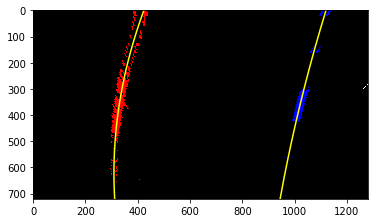

In [18]:
img11u = undistor_image(img11, objpoints, imgpoints, build_pickle=False)
binary = color_and_gradient_comb(img11u, debug=(False, False) )
binary_warped, _ = warp(binary, debug=False)
_ = find_lane_line(binary_warped, debug=True, boxes=False)

In [19]:
def find_second_frame(binary_warped, left_fit, right_fit, debug=False):
    """
    Find lane lines of next frame base on last left and right fits
    """
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    if debug:
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
        
    data = {
        "out_img": out_img,
        "left_fit": left_fit,
        "right_fit": right_fit,
        "left_fitx": left_fitx,
        "right_fitx": right_fitx,
        "ploty": ploty
    }
    return data

## Pipeline


In [20]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # line lie date from find_lane_line method 
        data = None
        radius_and_pos = (1,1,1)

    def check_first_time(self):
        self.detected = True
        self.last_data = self.data
        self.radius_and_pos = radius(self.data["ploty"],
                        self.data["left_fitx"],
                        self.data["right_fitx"],
                        height_m=30.0, width_m=3.7,
                        height_px=720.0, width_px=1200.0)

    def check(self):
        self.radius_and_pos = radius(self.data["ploty"],
                        self.data["left_fitx"],
                        self.data["right_fitx"],
                        height_m=30.0, width_m=3.7,
                        height_px=720.0, width_px=1200.0)
line = Line()

In [21]:
def process_image(image, debug=False, stacked=True):
    """
    Procces each frame of the video and return
    The plotted lane lane area over the image.
    """
    undistort = undistor_image(image, objpoints, imgpoints, build_pickle=False)
    binary = color_and_gradient_comb(undistort, debug=(False, False))
    warped, Minv = warp(binary, debug=False)

    if line.detected:
        line.data = find_second_frame(warped, line.data["left_fit"], line.data["right_fit"], debug=False)
        line.check()
    else:
        line.data = find_lane_line(warped, debug=False)
        line.check_first_time()

    plotted = plot_lane_area(warped, undistort, Minv, line.data["ploty"], line.data["left_fitx"], line.data["right_fitx"], debug=False)

    # Write Curvature Radius on image
    color=[0, 255, 0]
    lr, rr, pos = line.radius_and_pos
    direction = "left" if pos < 0 else "right"
    lcaption = "L[Curvature Radius={0}Km.]".format( round(lr/1000.0, 2) )
    rcaption = "R[Curvature Radius={0}Km.]".format( round(rr/1000.0, 2) )
    poscaption = "Positon {}m {} of the center".format(round(abs(pos),2), direction )
    if not stacked:
        cv2.putText(plotted, lcaption,(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,color,1,cv2.LINE_AA)
        cv2.putText(plotted, rcaption,(10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1,color,1,cv2.LINE_AA)
        cv2.putText(plotted, poscaption,(10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1,color,1,cv2.LINE_AA)
   
    if debug:
        _undistort = cv2.resize(undistort, (400, 240))
        scipy.misc.imsave('./undistort.jpg', _undistort)
        _binary = cv2.resize(binary, (400, 240))
        scipy.misc.imsave('./binary.jpg', _binary)
        _warped = cv2.resize(warped, (400, 240))
        scipy.misc.imsave('./warped.jpg', _warped)
        timestamp = datetime.utcnow().strftime('%Y_%m_%d_%H_%M_%S_%f')[:-3] 
        scipy.misc.imsave("debug/{}.jpg".format(timestamp), image)
    

    #if want to make video with binary or warped images
    if stacked:
        b = np.uint8(binary)
        bbb = np.dstack((b, b, b))*255
        w = np.uint8(warped)
        www = np.dstack((w, w, w))*255
        bbb = cv2.resize(bbb, (426, 240))
        www = cv2.resize(www, (426, 240))
        fill = cv2.resize(np.zeros_like(bbb), (428, 240) )
        
        cv2.putText(fill, lcaption,(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8,color,1,cv2.LINE_AA)
        cv2.putText(fill, rcaption,(10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.8,color,1,cv2.LINE_AA)
        cv2.putText(fill, poscaption,(10, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.7,color,1,cv2.LINE_AA)
        cv2.putText(fill, "<--- binary gradient + channels",(10, 180), cv2.FONT_HERSHEY_SIMPLEX, 0.7,color,1,cv2.LINE_AA)
        cv2.putText(fill, "bird's eye view perspective --->",(10, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.7,color,1,cv2.LINE_AA)
        
        bw = np.concatenate((bbb, fill ,www), axis=1)
        return np.concatenate((plotted, bw), axis=0)
    
    return plotted


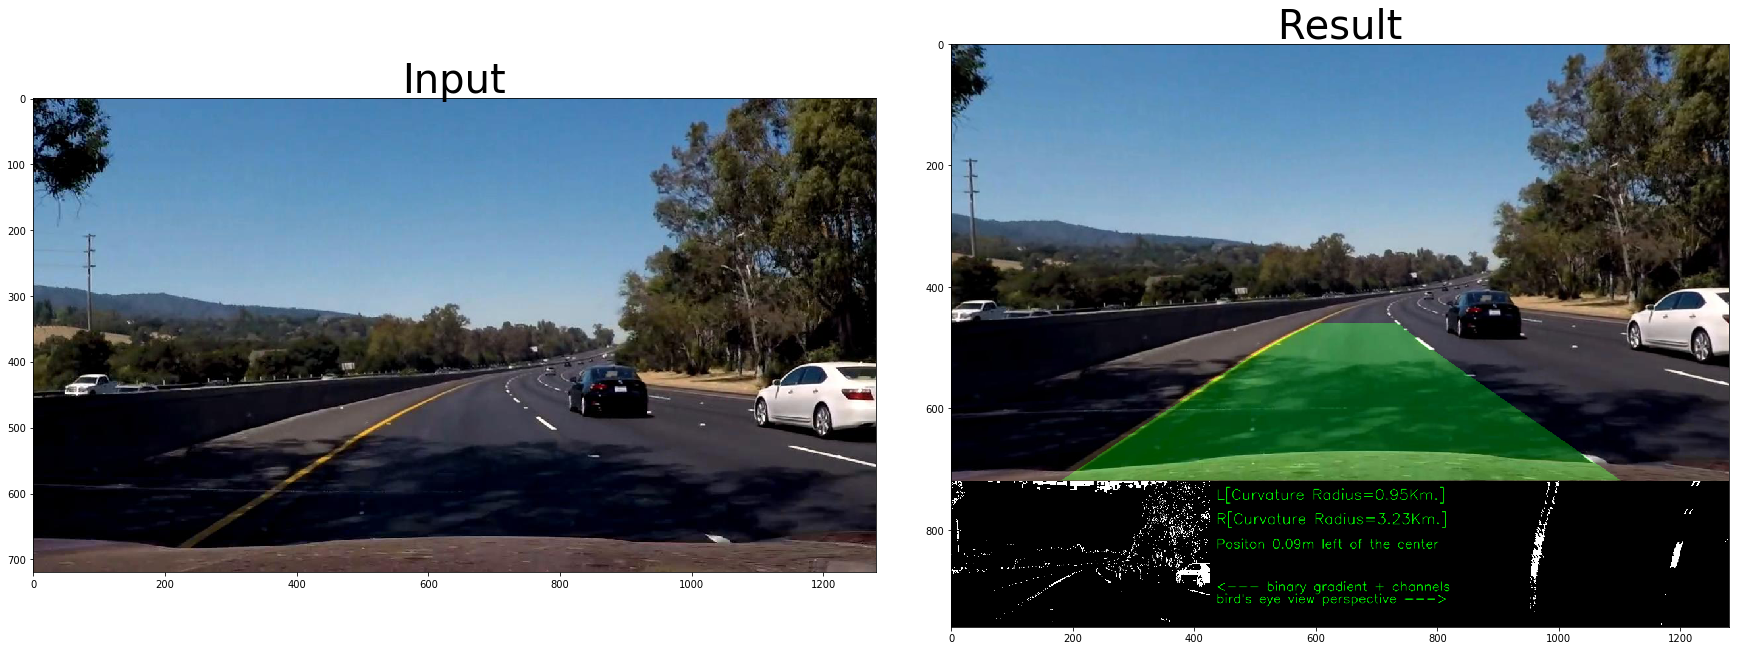

In [22]:
result = process_image(img11, stacked=True)
debug_images(img11, result, "Input", "Result")

In [23]:
result.shape

(960, 1280, 3)

In [24]:
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile('lab_out.mp4', audio=False)

[MoviePy] >>>> Building video lab_out.mp4
[MoviePy] Writing video lab_out.mp4


100%|█████████▉| 1260/1261 [05:11<00:00,  4.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: lab_out.mp4 

CPU times: user 5min 39s, sys: 1min 39s, total: 7min 18s
Wall time: 5min 12s
